In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(254)

In [2]:
LOCATION = 'tokyo'
# Get data for all years and store in a dictionary
annual_htrace = {}
annual_ptrace = {}
annual_hmean = {}
from common.harvester_fns import csv_solar_harvester

for yr in range(1995,2019):
    harvester = csv_solar_harvester(location=LOCATION, 
                                    year=yr,
                                    HENERGY_NOISE=0.0,
                                    PREDICTION_HORIZON=240*10, # lookahead horizon to predict energy
                                    PREDICTION_NOISE=0.000)
    done = False
    htrace=[]
    ptrace=[]
    while not done:
        _,henergy,penergy,_,done = harvester.step()
        htrace.append(henergy)
        ptrace.append(penergy)
    annual_hmean[yr] = np.mean(htrace)
    annual_htrace[yr] = htrace
    annual_ptrace[yr] = ptrace

In [3]:
#annual_xtrace[schm][yr] contains the trace of x variable for year=yr when using scheme=schm

annual_rq_trace = {}
annual_btrace = {}
annual_dc_trace = {}
annual_mismatch = {}
annual_utrace = {}

scheme_list = ['best','const','random', 'normal', 'uniform', 'random_day', 'worst']
for scheme in scheme_list:
    annual_rq_trace[scheme] = {}
    annual_btrace[scheme] = {}
    annual_dc_trace[scheme] = {}
    annual_mismatch[scheme] = {}
    annual_utrace[scheme] = {}

In [4]:
# Generate requests using different schemes
from common.requester_fns import best_rq_gen, const_rq_gen, random_rq_gen
from common.requester_fns import normal_rq_gen, uniform_rq_gen, random_day_rq_gen, worst_rq_gen

mindc = 0.1
for yr in range(1995,2019):
    htrace = np.array(annual_htrace[yr])
    hmean = np.mean(list(annual_hmean.values())) # mean of 10 years
    
    # Best mismatch
    annual_rq_trace['best'][yr] = best_rq_gen(htrace=htrace,
                                              hmean=hmean,
                                              mindc=mindc)
    
    # Constant request
    annual_rq_trace['const'][yr] = const_rq_gen(htrace=htrace,
                                                  hmean=hmean,
                                                  mindc=mindc)

    # Request is a random timeslot
    annual_rq_trace['random'][yr] = random_rq_gen(htrace=htrace,
                                                  hmean=hmean,
                                                  mindc=mindc)
    
    # Request is a normally distributed with mean=hmean
    annual_rq_trace['normal'][yr] = normal_rq_gen(htrace=htrace,
                                                  hmean=hmean,
                                                  mindc=mindc)
    
    # Request is a uniformly distributed with mean=hmean
    annual_rq_trace['uniform'][yr] = uniform_rq_gen(htrace=htrace,
                                                  hmean=hmean,
                                                  mindc=mindc)

    # Request corresponds to a random day profile
    annual_rq_trace['random_day'][yr] = random_day_rq_gen(htrace=htrace,
                                                  hmean=hmean,
                                                  mindc=mindc,
                                                  timesteps_per_day=240,
                                                  offset=120)
    
    # Request corresponds to the worst possible mismatch
    annual_rq_trace['worst'][yr] = worst_rq_gen(htrace=htrace,
                                                  hmean=hmean,
                                                  mindc=mindc,
                                                  timesteps_per_day=240)

In [5]:
# # Testing request generators
# yr = 1995
# scheme = 'best'
# rq_trace = annual_rq_trace[scheme][yr]
# plt.plot(rq_trace[0:2400])
# plt.ylim([0,1])

In [6]:
# scheme_list = ['best','const','random', 'normal', 'uniform', 'random_day', 'worst']
# Only use 6 schemes out of 7
scheme_list = ['best','worst','const','random', 'normal', 'random_day']

print("Average supply and request energies")
print("Year  hmean",end='    ')

for scheme in scheme_list:
    print(scheme.ljust(7), end='  ')
print("")
for yr in range(1995,2019):
    print(f'{yr} {annual_hmean[yr]:7.4f}',end='  ')
    for scheme in scheme_list:
        print(f'{np.mean(annual_rq_trace[scheme][yr]):7.4f}',end='  ')
    print("")

Average supply and request energies
Year  hmean    best     worst    const    random   normal   random_day  
1995  0.1319   0.1370   0.1370   0.1390   0.1370   0.1436   0.1370  
1996  0.1359   0.1382   0.1382   0.1390   0.1382   0.1438   0.1382  
1997  0.1367   0.1384   0.1384   0.1390   0.1384   0.1436   0.1384  
1998  0.1171   0.1329   0.1329   0.1390   0.1329   0.1437   0.1329  
1999  0.1348   0.1378   0.1378   0.1390   0.1378   0.1436   0.1378  
2000  0.1369   0.1385   0.1385   0.1390   0.1385   0.1437   0.1385  
2001  0.1377   0.1387   0.1387   0.1390   0.1387   0.1436   0.1387  
2002  0.1380   0.1387   0.1387   0.1390   0.1387   0.1436   0.1387  
2003  0.1281   0.1360   0.1360   0.1390   0.1360   0.1436   0.1360  
2004  0.1461   0.1410   0.1410   0.1390   0.1410   0.1436   0.1410  
2005  0.1385   0.1389   0.1389   0.1390   0.1389   0.1436   0.1389  
2006  0.1235   0.1347   0.1347   0.1390   0.1347   0.1438   0.1347  
2007  0.1415   0.1397   0.1397   0.1390   0.1397   0.1437   0.1

In [7]:
C_FACTOR = 1E-3
for yr in range(1995,2019):
    for scheme in scheme_list:
        htrace = annual_htrace[yr]
        rq_trace = annual_rq_trace[scheme][yr] 
        dc_trace = rq_trace # When dc_trace exactly follows req_trace

        dc_trace[dc_trace<0.1]=0.1
        dc_trace[dc_trace>1]=1

        mismatch_trace = (htrace-dc_trace)
        consumption = mismatch_trace*C_FACTOR
        btrace = consumption.cumsum()
        utrace = dc_trace/rq_trace
        utrace[utrace>1] = 1 # 0 < utility <=1

        annual_dc_trace[scheme][yr] = dc_trace
        annual_btrace[scheme][yr]   = btrace
        annual_utrace[scheme][yr]   = utrace
        annual_mismatch[scheme][yr] = mismatch_trace

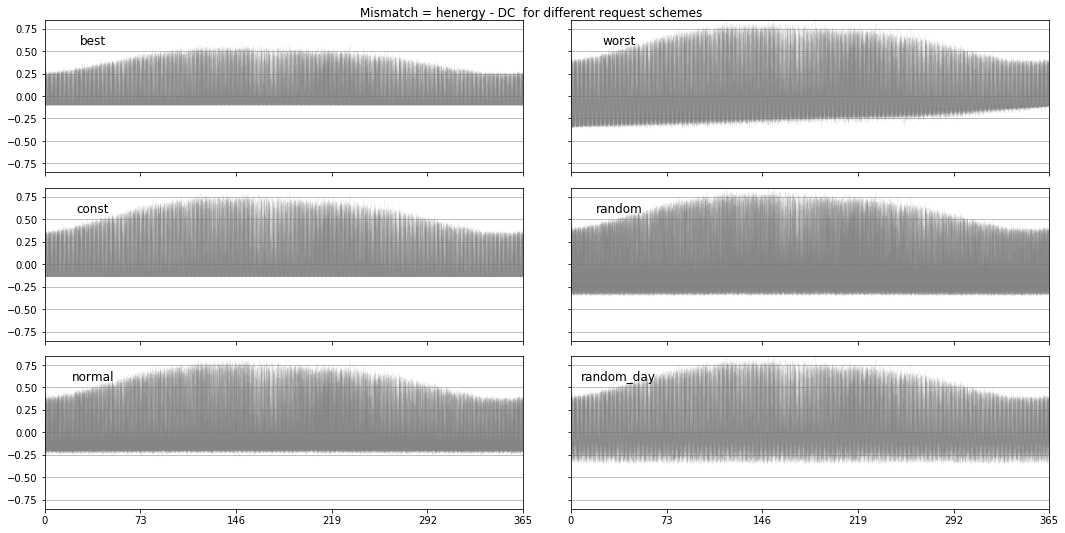

In [8]:
# For each scheme, show mismatch for all years
timesteps_per_day = 240
no_of_days = 365 #ignoring last days of leap years

fig, ax = plt.subplots(nrows=3,
                       ncols=2,
                       figsize=(18, 9), 
                       sharex=True, sharey=True,
                       gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
fig.suptitle("Mismatch = henergy - DC  for different request schemes",
             position=(0.5,0.9))
counter = 0
for i in range(3):
    for j in range(2):
        scheme = scheme_list[counter]
        for yr in range(1995,2019):
            ax[i][j].plot(annual_mismatch[scheme][yr],label=str(yr),color='tab:grey',alpha=0.1,linewidth=0.5)
            
            ax[i][j].yaxis.grid(True)
            ax[i][j].set_title(scheme, x=0.1, y=0.8)
            ax[i][j].set_ylim([-0.85,0.85])
            ax[i][j].set_xlim([0,no_of_days*timesteps_per_day])
            ax[i][j].set_xticks(np.arange(start=0,
                                          stop=timesteps_per_day*(no_of_days+1),
                                          step=timesteps_per_day*73))
            ax[i][j].set_xticklabels(np.arange(start=0,
                                               stop=no_of_days+1,
                                               step=73))

        counter += 1

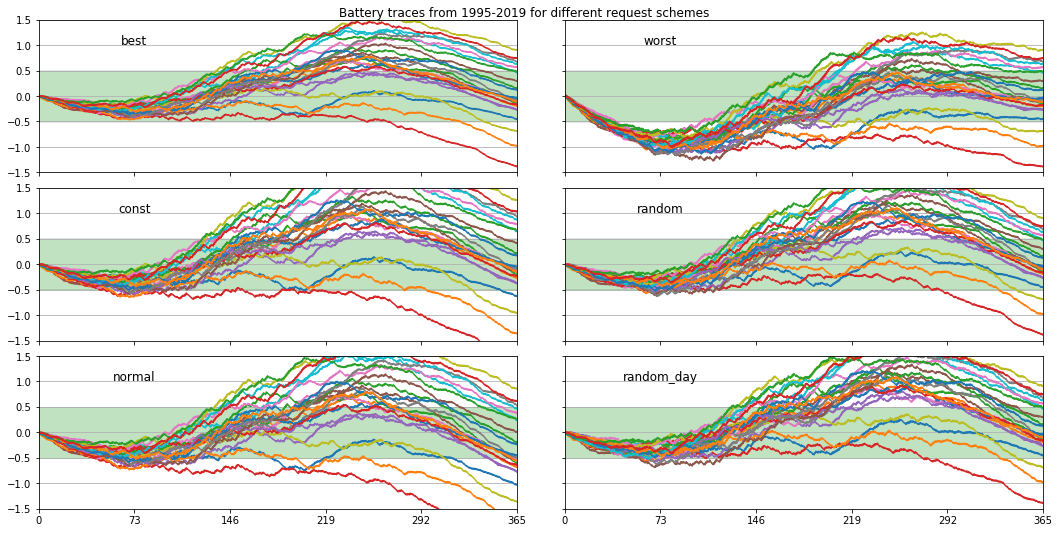

In [9]:
# For each scheme, show battery plots for all years
timesteps_per_day = 240
no_of_days = 365 #ignoring last days of leap years

fig, ax = plt.subplots(nrows=3,
                       ncols=2,
                       figsize=(18, 9), 
                       sharex=True, sharey=True,
                       gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
fig.suptitle("Battery traces from 1995-2019 for different request schemes",
             position=(0.5,0.9))
counter = 0
for i in range(3):
    for j in range(2):
        scheme = scheme_list[counter]
        for yr in range(1995,2019):
            # permissible battery range
            ax[i][j].fill_between(x=np.arange(0,timesteps_per_day*(no_of_days+1)),
                      y1=0.5,
                      y2=-0.5,
                      color='tab:green',
                      alpha = 0.01)
            # actual battery trace
            ax[i][j].plot(annual_btrace[scheme][yr],label=str(yr))
            
            ax[i][j].yaxis.grid(True)
            ax[i][j].set_title(scheme, x=0.2, y=0.8)
            ax[i][j].set_ylim([-1.5,1.5])
            ax[i][j].set_xlim([0,no_of_days*timesteps_per_day])
            ax[i][j].set_xticks(np.arange(start=0,
                                          stop=timesteps_per_day*(no_of_days+1),
                                          step=timesteps_per_day*73))
            ax[i][j].set_xticklabels(np.arange(start=0,
                                               stop=no_of_days+1,
                                               step=73))

        counter += 1

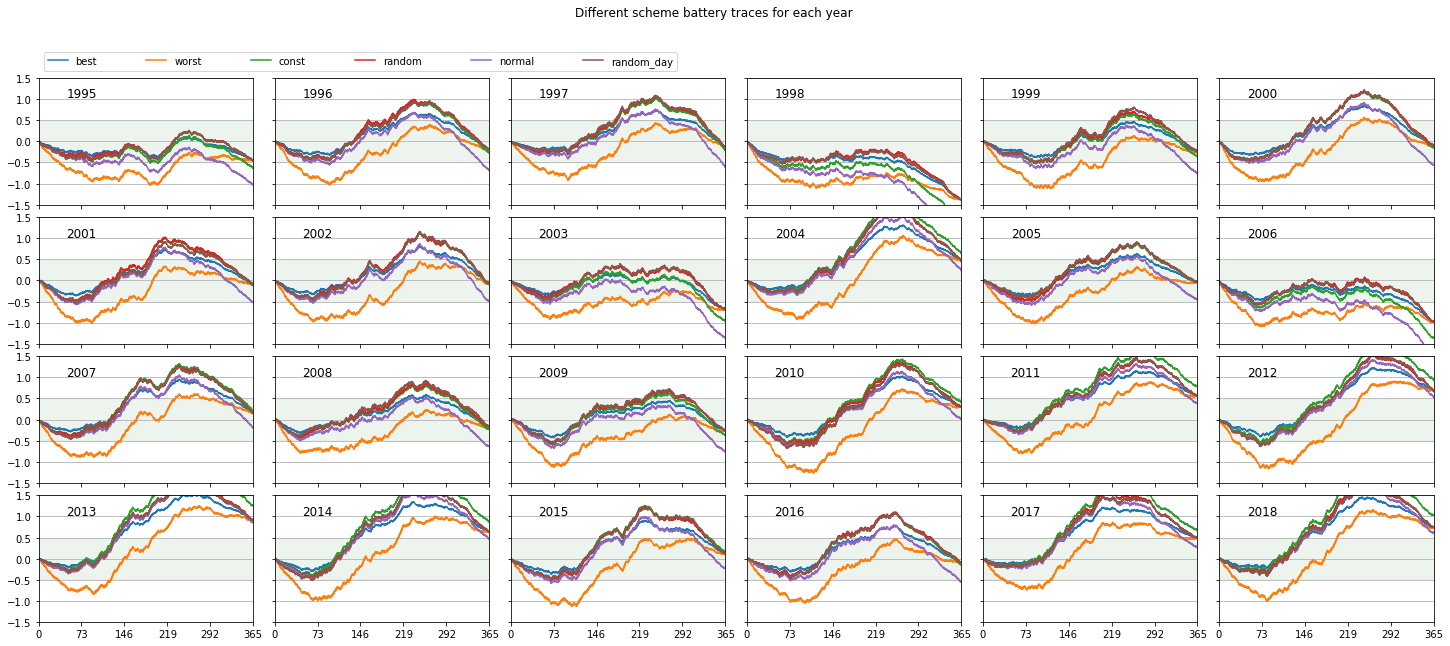

In [10]:
# For each year, show battery plots for all schemes

timesteps_per_day = 240
no_of_days = 365 #ignoring last days of leap years
no_of_rows = 4
no_of_cols = 6
fig, ax = plt.subplots(nrows=no_of_rows,
                       ncols=no_of_cols,
                       figsize=(25, 10), 
                       sharex=True, sharey=True,
                       gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
fig.suptitle("Different scheme battery traces for each year")

counter = 0
for i in range(no_of_rows):
    for j in range(no_of_cols):
        yr = 1995 + counter
        for scheme in scheme_list:
            # permissible battery rangeE
            ax[i][j].fill_between(x=np.arange(0,timesteps_per_day*(no_of_days+1)),
                      y1=0.5,
                      y2=-0.5,
                      color='tab:green',
                      alpha = 0.01)
            # actual battery trace
            ax[i][j].plot(annual_btrace[scheme][yr],label=str(scheme))
            
            ax[i][j].yaxis.grid(True)
            ax[i][j].set_title(str(yr), x=0.2, y=0.8)
            ax[i][j].set_ylim([-1.5,1.5])
            ax[i][j].set_xlim([0,no_of_days*timesteps_per_day])
            ax[i][j].set_xticks(np.arange(start=0,
                                          stop=timesteps_per_day*(no_of_days+1),
                                          step=timesteps_per_day*73))
            ax[i][j].set_xticklabels(np.arange(start=0,
                                               stop=no_of_days+1,
                                               step=73))
            ax[i][j].set_yticks([-1.5,-1,-0.5,0,0.5,1.0,1.5])
        #bbox_to_anchor = (x0, y0, width, height)
        ax[0][0].legend(loc="lower left",ncol=6,bbox_to_anchor=(0., 1.02, 3., .2),mode="expand")

        counter += 1

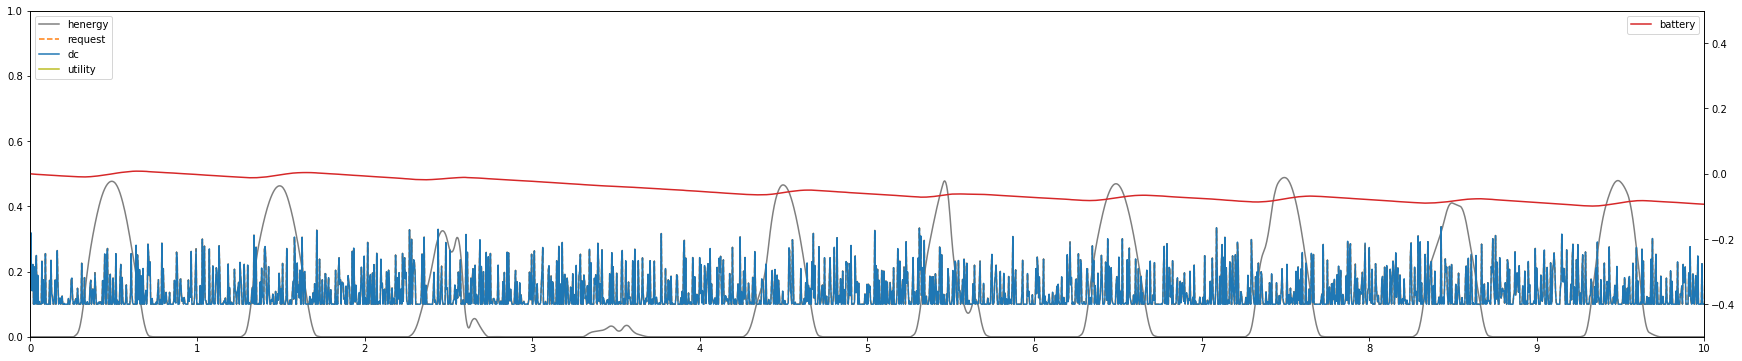

In [11]:
# Daily trace plots
yr = 1995
scheme = 'random'
timesteps_per_day = 240

start_indx = 0*timesteps_per_day
no_of_days = 10
end_indx = start_indx + int(timesteps_per_day*no_of_days)


htrace = annual_htrace[yr]
rq_trace = annual_rq_trace[scheme][yr]
dc_trace = annual_dc_trace[scheme][yr]
btrace = annual_btrace[scheme][yr]
utrace = annual_utrace[scheme][yr]
mismatch_trace = annual_mismatch[scheme][yr]



fig, ax = plt.subplots(1,figsize=(30, 6))
ax2 = ax.twinx()

ax.plot(htrace[start_indx:end_indx],   color='tab:grey', label='henergy')
ax.plot(rq_trace[start_indx:end_indx], color='tab:orange', linestyle='--', label='request')
ax.plot(dc_trace[start_indx:end_indx], color='tab:blue',  label='dc')
ax.plot(utrace[start_indx:end_indx],   color='tab:olive', label='utility')

ax2.plot(btrace[start_indx:end_indx],         color='tab:red', label='battery')
# ax2.plot(mismatch_trace[start_indx:end_indx], color='tab:cyan', label='mismatch')

ax.set_ylim([0,1])
ax2.set_ylim([-0.5,0.5])

ax.set_xlim([0,timesteps_per_day*no_of_days])
ax.set_xticks(np.arange(start=0,
                        stop=timesteps_per_day*(no_of_days+1),
                        step=timesteps_per_day))
ax.set_xticklabels(np.arange(start=0,
                             stop=no_of_days+1,
                             step=1))
# ax.xaxis.grid(True)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')